In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

import subprocess


In [5]:
def splitter(test):
    tmp = test.split()
    tst = [tmp[4]]
    tst += tmp[8].split("/")[1].split("_")
    return tst

def convert(s):
    if np.can_cast(s, to="int"):
        return int(s)
    x, u, b = s[:-1], s[-1], 1000
    return float(x) * {"K":b, "M":b**2, "G":b**3}[u]


## Key Size

### Size of bootstrap keys

In [9]:
temp = subprocess.getoutput("ls -lah keys/80_1024*/b*") \
     + subprocess.getoutput("ls -lah keys/std62_2048*/b*")

df = pd.DataFrame(
    [splitter(line) for line in temp.split("\n")], columns=["disk","bs","poly","dim","base_log","level"])
df["disk"] = df["disk"].apply(convert)/1e6

#df.head()
df.pivot_table(values="disk", index="level", columns=["poly", "base_log"], aggfunc="mean")


poly       1024                                2048                          \
base_log      3      4      5      6      7       3       4       5       6   
level                                                                         
3         193.0  193.0  193.0  193.0  193.0     NaN   769.0   769.0   769.0   
4         257.0  257.0  257.0  257.0  257.0  1100.0  1100.0  1100.0  1100.0   
5         321.0  321.0  321.0  321.0  321.0  1300.0  1300.0  1300.0  1300.0   
6         385.0  385.0  385.0  385.0  385.0  1600.0  1600.0  1600.0  1600.0   
7         449.0  449.0  449.0  449.0  449.0  1800.0  1800.0  1800.0  1800.0   
8         513.0  513.0  513.0  513.0  513.0  2100.0  2100.0  2100.0  2100.0   
9         577.0  577.0  577.0  577.0  577.0  2300.0  2300.0  2300.0  2300.0   

poly              
base_log       7  
level             
3          769.0  
4         1100.0  
5         1300.0  
6         1600.0  
7         1800.0  
8         2100.0  
9         2300.0

### Size of secret keys

In [10]:
temp = subprocess.getoutput("ls -lah keys/80_1024*/sk*")\
     + subprocess.getoutput("ls -lah keys/std62_2048*/sk*")

df = pd.DataFrame(
    [splitter(line) for line in temp.split("\n")], columns=["disk","bs","poly","dim","base_log","level"])
df["disk"] = df["disk"].apply(convert)/1e3

#df.head()
df.pivot_table(values="disk", index="level", columns=["poly", "base_log"])


poly      1024                          2048                        
base_log     3     4     5     6     7     3     4     5     6     7
level                                                               
3         2.15  2.15  2.15  2.15  2.15  4.20  4.15  4.15  4.15  4.15
4         2.15  2.15  2.15  2.15  2.15  4.15  4.15  4.15  4.15  4.15
5         2.15  2.15  2.15  2.15  2.15  4.15  4.15  4.15  4.15  4.15
6         2.15  2.15  2.15  2.15  2.15  4.15  4.15  4.15  4.15  4.15
7         2.15  2.15  2.15  2.15  2.15  4.15  4.15  4.15  4.15  4.15
8         2.15  2.15  2.15  2.15  2.15  4.15  4.15  4.15  4.15  4.15
9         2.15  2.15  2.15  2.15  2.15  4.15  4.15  4.15  4.15  4.15

## Timing and performance stats

In [21]:
temp = !cat boot_stats.txt

for base_log in range(3,8):
    for level in range(3,10):
        #test = "keys/80_1024_1_%d_%d"%(base_log,level)
        test = "keys/std62_2048_1_%d_%d"%(base_log,level)
        if test not in [line.split()[0] for line in temp]:
            print("*"*80, "\n", test, "\n", "*"*80, "\n")
            !target/debug/test_boot $base_log $level 
            print("*"*80, "\n\n")
        

In [22]:
def splitter2(test):
    tmp = test.replace("NA","0").split()
    return tmp[0].split("/")[1].split("_") + [int(item) for item in tmp[1:]]

temp = !cat boot_stats.txt

[splitter2(line) for line in temp]
df2 = pd.DataFrame([splitter2(line) for line in temp], 
        columns=["bs","poly","dim","base_log","level","free", "sk_load", "bsk_load", "boot"])

df2.head()
                                                     

,bs,poly,dim,base_log,level,free,sk_load,bsk_load,boot
0,80,1024,1,5,3,5,13,22613,2893
1,80,1024,1,6,4,14,13,24416,3779
2,80,1024,1,3,3,0,19,18493,2880
3,80,1024,1,3,4,0,22,23930,3735
4,80,1024,1,3,6,8,16,35600,5067


### Number of free bits

In [23]:
df2.pivot_table(values="free", index="level", columns=["poly", "base_log"])


poly     1024                 2048                
base_log    3   4   5   6   7    3   4   5   6   7
level                                             
3           0   0   5   8  11    0   0   4   7  10
4           0   6  10  14  18    0   5   9  13  17
5           5  10  15  20  21    4   9  14  19  24
6           8  14  20  22  21    7  13  19  25  31
7          11  18  23  22  21   10  17  24  31  38
8          14  22  23  22  21   13  21  29  37  42
9          17  24  23  22  21   16  25  34  42  42

### Secret key load time

In [24]:
tmp = df2.pivot_table(values="sk_load", index="level", columns=["poly", "base_log"])
#print(tmp.mean().mean())
tmp


poly      1024                          2048                        
base_log     3     4     5     6     7     3     4     5     6     7
level                                                               
3         14.0   9.5  13.0   8.0  19.0  27.0  22.0  12.0   8.0  38.0
4         22.0  12.0  15.0  13.0   8.0  26.0  18.0  18.0  20.0   9.0
5         11.0   9.0  23.0   8.0  13.0  17.0  20.0  19.0  11.0  26.0
6         12.5  17.0  19.0  46.0  18.0  11.0   7.0  17.0  31.0  26.0
7         10.5  15.5  17.0  17.0   7.0   6.0  19.0  17.0  11.0  36.0
8          8.0  15.5  14.0  18.0  10.0  17.0  19.0  14.0  17.0  13.0
9          9.5  22.0  29.0  10.0   6.0  25.0  24.0  23.0  12.0   8.0

### Bootstrap key load time

In [25]:
tmp = (df2.pivot_table(values="bsk_load", index="level", columns=["poly", "base_log"])/1000.).round(1)
#print(tmp.mean(axis=1).values)
tmp


poly      1024                           2048                            
base_log     3     4     5     6     7      3      4      5      6      7
level                                                                    
3         18.5  18.5  22.6  18.0  19.6   72.9   73.8   76.0   73.5   73.5
4         24.1  23.9  23.6  24.4  24.1  100.7   95.3   97.4   94.5   95.9
5         29.7  29.4  29.8  30.7  30.8  122.0  122.3  127.8  121.0  137.3
6         35.6  36.2  36.0  46.5  38.0  146.0  149.4  157.2  157.4  149.0
7         41.4  43.5  52.5  42.6  44.9  170.9  170.7  168.5  176.7  180.2
8         47.7  49.4  48.7  62.4  48.9  194.9  194.3  194.9  212.1  205.1
9         53.1  55.4  56.4  62.3  58.6  223.9  246.8  225.7  226.3  224.1

### Simple bootstrap time

In [27]:
tmp = (df2.pivot_table(values="boot", index="level", columns=["poly", "base_log"])/1000.).round(1)
#print(tmp.mean(axis=1).values)
tmp

poly     1024                      2048                        
base_log    3    4    5    6    7     3     4     5     6     7
level                                                          
3         3.0  3.0  2.9  2.9  3.0  11.7  11.9  11.7  12.0  11.9
4         3.8  3.7  3.7  3.8  3.7  14.6  14.6  15.0  14.2  15.1
5         4.4  4.4  4.4  4.6  4.4  17.6  17.5  17.7  17.5  18.2
6         5.1  5.2  5.1  5.2  5.3  20.7  20.6  20.2  20.4  21.3
7         5.9  6.1  5.8  5.9  5.9  23.3  23.5  23.4  23.4  24.3
8         6.6  6.8  6.7  6.9  6.5  26.2  26.5  26.1  26.6  26.5
9         7.3  7.3  7.7  7.4  7.7  29.4  31.4  29.9  30.9  30.2

In [ ]:
np.exp(-np.log(2)/(24*7))

0.9996562360941261

## tune transform function to range

x is on range [0,400] while most values less than 200

objective
- squash output range to half, i.e. [0,200]
- 80% output range should map to lower half of input (where most values lay)
- middle range should approx preserve delta, higher range more like log delta


In [383]:
x = np.linspace(0,400,1000)
x0 = x[0]
x1 = x[-1]

def sigmoid(x, k_n=1, k_p=1):
    k = k_p*(x>0) + k_n*(x<=0) 
    return 1/(1 + np.exp(-k*x))

g = lambda uu: np.clip(uu, 20, 400)

def normed(u, f):
    lower = f(g(x0))
    upper = f(g(x1))
    return (f(g(u))-lower)/(upper-lower)

log20 = lambda v: np.log(v)/np.log(20)


0.0 200.0
0.0 1.0
35 37.36086785028503 3.5 6.68173584405443 0.1788431647474017
50 61.17307210414449 5.0 6.681735844054465 0.10922674984638832
70 83.63651048223689 7.0 6.681735844054472 0.07989017960611318
100 107.44871473609638 10.0 6.681735844054472 0.062185349173002315
150 134.51823037256142 15.0 6.6817358440544865 0.04967160083468809
180 146.69031653683388 18.0 6.68173584405443 0.04554994495752314
200 153.72435736804815 20.0 6.681735844054458 0.0434656937810902
250 168.62178684024082 25.0 6.68173584405443 0.03962557845733766
400 200.0 40.0 3.4244244614488366 0.01712212230724418


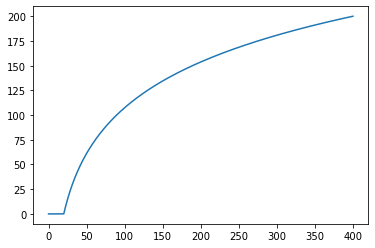

In [385]:
#f = lambda u: sigmoid(u-70, 0.0125, 0.0125)
#f = lambda u: u**0.1 - 30**0.1
f = lambda u: log20(u)-1

def t(x):
    #return np.log(np.clip(x, 1, 1000))
    #return (np.log10(10.+x)-1.)
    #return 200*(sigmoid(0.02*(x-100))-0.1)*1.1
    #return 200*(sigmoid(0.02*(x-140))-0.05)*1.05
    #return 200*np.log10(-1.1+12*sigmoid(0.01*(x-150)))
    #return 200*np.log10(0.6+9.4*sigmoid(0.02*(x-150)))
    #return 200*np.log10(0.1+9.9*sigmoid(0.015*(x-150)))
    #return 200*(sigmoid(0.017*(x-100))-0.15)/(1-0.15) ## this is the one
    #return 1*(np.log(10+np.clip(x, 30, 400))-np.log(40))
    return 200*normed(x, f)
    #return 200*(sigmoid(np.clip(x, 30, 400)-100, 0.01, 0.01)-0.33)/(0.96-0.33)
    #return 200*(sigmoid(np.clip(x, 30, 400)-70, 0.01, 0.01)-0.40)/(0.97-0.40)
    #return 200*(sigmoid(np.clip(x, 30, 400)-50, 0.01, 0.01)-0.45)/(0.97-0.45)
    #return 200*(sigmoid(np.clip(x, 30, 400)-70, 0.0125, 0.0125)-0.375)/(0.985-0.375)

y = t(x)

print(min(y),max(y))
print(f(g(x0)),f(g(x1)))
for xx in [35, 50, 70, 100, 150, 180, 200, 250, 400]:
    print(xx, t(xx), 0.1*xx, (t(xx*1.05)-t(xx*0.95)), (t(xx*1.05)-t(xx*0.95))/t(xx))

plt.plot(x, y)
plt.show()


In [386]:
!tail hourly_stats.txt


data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 119569
data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 119387
data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 119050
data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 119860
data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 118790
data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 118974
data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 118715
data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 120604
data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 120736
data/80_1024_1_5_6/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 121277


In [387]:
!tail rolling_stats.txt


80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 1 17957 10 10
80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 2 17968 13 13
80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 3 17839 16 16
80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 4 17825 19 19
80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 5 17833 22 22
80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 6 17946 25 25
80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 7 17827 28 28
80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 8 17853 31 31
80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 9 17854 34 34
80_1024_1_7_7 CGM_p77_24h_2_3_400_TIR 8 10 17821 37 37


In [388]:
!tail scores_stats.txt


80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 22 3164
80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 23 3172
80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 24 3193
80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 25 3151
80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 26 3184
80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 27 3180
80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 28 3241
80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 29 3135
80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 30 3152
80_1024_1_5_4 CGM_p77_24h_2_3_400 LOG 31 3189


In [419]:
def splitter_scores(test):
    tmp = test.replace("NA","0").split()
    return ["_".join(tmp[0:3])] + tmp[0].split("_") + tmp[1:3] + [int(item) for item in tmp[-2:]]

temp = !cat scores_stats.txt

df_scores = pd.DataFrame([splitter_scores(line) for line in temp], 
        columns=["id", "bs","poly","dim","base_log","level","data","func", "idx", "time"])


print(df_scores["poly"].unique(), df_scores["func"].unique())
df_scores.head()


['1024'] ['TIR' 'H70' 'H54' 'GVP' 'LOG']


,id,bs,poly,dim,base_log,level,data,func,idx,time
0,80_1024_1_6_4_CGM_p77_24h_2_3_400_TIR,80,1024,1,6,4,CGM_p77_24h_2_3_400,TIR,0,3805
1,80_1024_1_6_4_CGM_p77_24h_2_3_400_TIR,80,1024,1,6,4,CGM_p77_24h_2_3_400,TIR,1,3754
2,80_1024_1_6_4_CGM_p77_24h_2_3_400_TIR,80,1024,1,6,4,CGM_p77_24h_2_3_400,TIR,2,3775
3,80_1024_1_6_4_CGM_p77_24h_2_3_400_TIR,80,1024,1,6,4,CGM_p77_24h_2_3_400,TIR,3,3754
4,80_1024_1_6_4_CGM_p77_24h_2_3_400_TIR,80,1024,1,6,4,CGM_p77_24h_2_3_400,TIR,4,3758


In [421]:
df_scores.pivot_table(values="time", index=["func","level"], columns=["data", "base_log"])


data       CGM_p77_24h_2_3_400                                         \
base_log                     3            4            5            6   
func level                                                              
GVP  3                     NaN  2571.296167  2579.250871  2565.118467   
     4             3222.846690  3229.135889  3209.404181  3382.472158   
     5             3856.515679  3920.477352  3866.756098  3914.536585   
     6             4551.707317  4535.181185  4556.080139  4539.714286   
     7             5148.634146  5197.414634  5172.585366  5198.149826   
H54  4                     NaN          NaN          NaN  3716.534722   
H70  4                     NaN          NaN          NaN  3764.812500   
LOG  3                     NaN          NaN          NaN          NaN   
     4                     NaN          NaN  3230.583333          NaN   
     5             3877.246528          NaN  3856.065972          NaN   
     6                     NaN  4511.829861  4489.097561  4508.836806   
     7                     NaN          NaN          NaN  5182.440972   
TIR  3                     NaN  2615.451389  2577.937500  2572.937500   
     4             3258.142361  3226.527778  3232.215278  3492.340278   
     5             3880.881944  3897.486111  3878.045139  3906.440972   
     6             4513.795139  4560.756944  4545.826389  4538.836806   
     7             5189.222222  5183.142361  5184.166667  5249.767361   

data                    CGM_p77_24h_3_3_400                            \
base_log              7                   4            5            6   
func level                                                              
GVP  3      2558.550523                 NaN          NaN          NaN   
     4      3235.379791                 NaN          NaN          NaN   
     5      3913.891986                 NaN          NaN          NaN   
     6      4653.170732                 NaN          NaN          NaN   
     7      5210.386760                 NaN          NaN          NaN   
H54  4              NaN                 NaN          NaN          NaN   
H70  4              NaN                 NaN          NaN          NaN   
LOG  3      2536.000000                 NaN          NaN          NaN   
     4              NaN                 NaN          NaN          NaN   
     5              NaN                 NaN          NaN          NaN   
     6              NaN                 NaN          NaN          NaN   
     7              NaN                 NaN          NaN          NaN   
TIR  3      2576.239583                 NaN          NaN          NaN   
     4      3214.024306                 NaN          NaN  3225.888889   
     5      3875.267361                 NaN  3868.631944          NaN   
     6      4532.031250         4565.954861          NaN  4547.465278   
     7      5219.680556                 NaN          NaN          NaN   

data       CGM_p77_24h_4_3_400                            
base_log                     4            5            6  
func level                                                
GVP  3                     NaN          NaN          NaN  
     4                     NaN          NaN          NaN  
     5                     NaN          NaN          NaN  
     6                     NaN          NaN          NaN  
     7                     NaN          NaN          NaN  
H54  4                     NaN          NaN          NaN  
H70  4                     NaN          NaN          NaN  
LOG  3                     NaN          NaN          NaN  
     4                     NaN          NaN          NaN  
     5                     NaN          NaN          NaN  
     6                     NaN          NaN          NaN  
     7                     NaN          NaN          NaN  
TIR  3                     NaN          NaN          NaN  
     4                     NaN          NaN  3222.409722  
     5                     NaN  3874.506944          NaN  
     6          

In [426]:
tmp = df_scores[["id","func","time"]].groupby(["func", "id"]).describe()["time"][["mean","std","25%","75%"]]
tmp["rse"] = tmp["std"]/tmp["mean"]
tmp.loc["GVP"]

,mean,std,25%,75%,rse
id,,,,,
80_1024_1_3_4_CGM_p77_24h_2_3_400_GVP,3222.846690,57.679281,3185.0,3257.50,0.017897
80_1024_1_3_5_CGM_p77_24h_2_3_400_GVP,3856.515679,63.597557,3810.0,3897.00,0.016491
80_1024_1_3_6_CGM_p77_24h_2_3_400_GVP,4551.707317,70.316403,4505.0,4591.00,0.015448
80_1024_1_3_7_CGM_p77_24h_2_3_400_GVP,5148.634146,84.464015,5097.0,5197.00,0.016405
80_1024_1_4_3_CGM_p77_24h_2_3_400_GVP,2571.296167,48.928585,2536.5,2603.00,0.019029
80_1024_1_4_4_CGM_p77_24h_2_3_400_GVP,3229.135889,53.592078,3192.0,3263.50,0.016596
80_1024_1_4_5_CGM_p77_24h_2_3_400_GVP,3920.477352,59.142462,3881.5,3958.00,0.015086
80_1024_1_4_6_CGM_p77_24h_2_3_400_GVP,4535.181185,78.690253,4476.0,4587.50,0.017351
80_1024_1_4_7_CGM_p77_24h_2_3_400_GVP,5197.414634,81.038359,5142.5,5257.00,0.015592


In [427]:
tmp.loc["TIR"]

,mean,std,25%,75%,rse
id,,,,,
80_1024_1_3_4_CGM_p77_24h_2_3_400_TIR,3258.142361,52.662397,3221.00,3295.50,0.016163
80_1024_1_3_5_CGM_p77_24h_2_3_400_TIR,3880.881944,58.214310,3839.50,3923.00,0.015000
80_1024_1_3_6_CGM_p77_24h_2_3_400_TIR,4513.795139,81.666248,4454.50,4563.25,0.018093
80_1024_1_3_7_CGM_p77_24h_2_3_400_TIR,5189.222222,75.818548,5140.75,5230.00,0.014611
80_1024_1_4_3_CGM_p77_24h_2_3_400_TIR,2615.451389,42.713506,2591.00,2634.50,0.016331
80_1024_1_4_4_CGM_p77_24h_2_3_400_TIR,3226.527778,57.688149,3183.00,3261.25,0.017879
80_1024_1_4_5_CGM_p77_24h_2_3_400_TIR,3897.486111,62.971094,3853.75,3944.00,0.016157
80_1024_1_4_6_CGM_p77_24h_2_3_400_TIR,4560.756944,68.617533,4512.75,4605.25,0.015045
80_1024_1_4_6_CGM_p77_24h_3_3_400_TIR,4565.954861,71.120901,4521.00,4619.00,0.015576


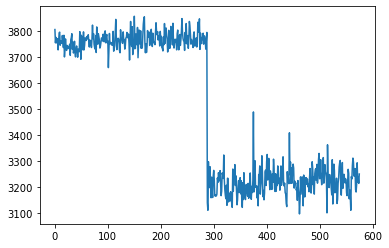

In [446]:
df_scores.loc[df_scores["id"]=="80_1024_1_6_4_CGM_p77_24h_2_3_400_TIR","time"].reset_index(drop=True).plot()
plt.show()

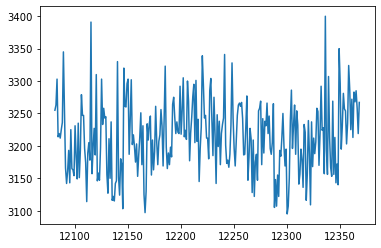

In [441]:
df_scores.loc[df_scores["id"]=="80_1024_1_7_4_CGM_p77_24h_2_3_400_TIR","time"].plot()
plt.show()

In [434]:
!head hourly_stats.txt


data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 86772
data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 86374
data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 86071
data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 86059
data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 86406
data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 86038
data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 85929
data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 85919
data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 85546
data/80_1024_1_6_4/CGM_p77_24h_2_3_400_cgm_hourly.enc 91505


In [433]:
!tail hourly_stats.txt


data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 68852
data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 68798
data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 67561
data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 67618
data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 67599
data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 67852
data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 68199
data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 67882
data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 68496
data/80_1024_1_6_3/CGM_p77_24h_2_3_400_GVP_CGM_hourly.enc 68215


In [437]:
def splitter_hourly(test): #foo, bar, baz, qux
    tmp = test.split()
    tst = tmp[0].split("/")
    foo = tst[2].split("_")
    keys, data, func, time = tst[1], "_".join(foo[:6]), foo[6].upper(), int(tmp[1])
    return [keys+"_"+data+"_"+func] + keys.split("_") + [data, func, time]

temp = !cat hourly_stats.txt

df_hourly = pd.DataFrame([splitter_hourly(line) for line in temp], 
        columns=["id", "bs","poly","dim","base_log","level","data","func", "time"])


print(df_hourly["poly"].unique(), df_hourly["func"].unique())
df_hourly.head()


['1024'] ['CGM' 'TIR' 'H54' 'H70' 'GVP']


,id,bs,poly,dim,base_log,level,data,func,time
0,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,86772
1,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,86374
2,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,86071
3,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,86059
4,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,86406


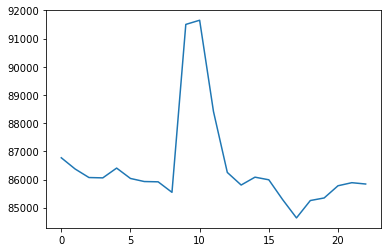

In [440]:
df_hourly.loc[df_hourly["id"]=="80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM","time"].plot()
plt.show()


In [447]:
df_hourly.pivot_table(values="time", index=["func","level"], columns=["data", "base_log"])


data       CGM_p77_24h_2_3_400                                               \
base_log                     3              4              5              6   
func level                                                                    
CGM  3                     NaN            NaN   72360.166667   68934.500000   
     4                     NaN   86636.000000   86373.416667   86471.869565   
     5           103700.916667  103325.208333  103882.041667  102963.125000   
     6           119978.958333  121738.250000  121271.291667  121297.291667   
     7           138655.166667  137874.708333  137911.416667  137334.333333   
GVP  3                     NaN            NaN            NaN   68027.190476   
     4                     NaN            NaN   85812.130435            NaN   
     5           102985.086957            NaN  102740.043478            NaN   
     6                     NaN  119692.652174  119801.739130  120219.130435   
     7                     NaN            NaN            NaN  137853.869565   
H54  4                     NaN            NaN            NaN   85787.958333   
H70  4                     NaN            NaN            NaN   85489.750000   
TIR  3                     NaN            NaN   68676.083333            NaN   
     4                     NaN            NaN   85296.500000            NaN   
     5           102407.500000            NaN  102802.000000            NaN   
     6                     NaN  121378.000000  121809.333333  120524.708333   
     7                     NaN            NaN            NaN  137846.083333   

data                      CGM_p77_24h_3_3_400                                \
base_log                7                   3              4              5   
func level                                                                    
CGM  3       68747.500000                 NaN            NaN            NaN   
     4       85747.041667                 NaN            NaN   85972.458333   
     5      103330.916667       104702.666667            NaN  104942.083333   
     6      121233.916667                 NaN  122530.041667  120119.000000   
     7      139976.625000       138632.333333            NaN            NaN   
GVP  3       67859.347826                 NaN            NaN            NaN   
     4                NaN                 NaN            NaN            NaN   
     5                NaN                 NaN            NaN            NaN   
     6                NaN                 NaN            NaN            NaN   
     7                NaN                 NaN            NaN            NaN   
H54  4                NaN                 NaN            NaN            NaN   
H70  4                NaN                 NaN            NaN            NaN   
TIR  3       68226.458333                 NaN            NaN            NaN   
     4                NaN                 NaN            NaN            NaN   
     5                NaN                 NaN            NaN            NaN   
     6                NaN                 NaN            NaN            NaN   
     7                NaN                 NaN            NaN            NaN   

data                                 CGM_p77_24h_4_3_400              \
base_log                6          7                   3           4   
func level                                                             
CGM  3       69029.416667  68785.125                 NaN         NaN   
     4       86579.875000        NaN                 NaN         NaN   
     5                NaN        NaN          104134.375         NaN   
     6      120002.708333        NaN                 NaN  122666.375   
     7      139882.041667        NaN                 NaN         NaN   
GVP  3                NaN        NaN                 NaN         NaN   
     4                NaN        NaN                 NaN         NaN   
     5                NaN        NaN                 NaN         NaN   
     6                NaN        NaN          

In [448]:
!head rolling_stats.txt


80_1024_1_6_4 CGM_p77_24h_2_3_400 8 0 27150 7 7
80_1024_1_6_4 CGM_p77_24h_2_3_400 8 1 11648 10 10
80_1024_1_6_4 CGM_p77_24h_2_3_400 8 2 11394 13 13
80_1024_1_6_4 CGM_p77_24h_2_3_400 8 3 11516 16 16
80_1024_1_6_4 CGM_p77_24h_2_3_400 8 4 11772 19 19
80_1024_1_6_4 CGM_p77_24h_2_3_400 8 5 11425 22 22
80_1024_1_6_4 CGM_p77_24h_2_3_400 8 6 11624 25 25
80_1024_1_6_4 CGM_p77_24h_2_3_400 8 7 11770 28 28
80_1024_1_6_4 CGM_p77_24h_2_3_400 8 8 11712 31 31
80_1024_1_6_4 CGM_p77_24h_2_3_400 8 9 11606 34 34


In [449]:
!tail rolling_stats.txt


80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 12 13506 43 43
80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 13 13620 46 46
80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 14 13579 49 49
80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 15 13527 52 52
80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 16 13449 55 55
80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 17 13530 58 58
80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 18 13632 61 61
80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 19 13553 64 64
80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 20 13476 67 67
80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 21 13511 70 70


In [453]:
def splitter_rolling(test): #foo, bar, baz, qux
    tmp = test.split()
    tst = tmp[1].split("_")
    if len(tst)==6:
        tst.append("CGM")
    keys, data, func = tmp[0], "_".join(tst[:6]), tst[6].upper()
    return [keys+"_"+data+"_"+func] + keys.split("_") + [data, func] + [int(item) for item in tmp[2:]]

#splitter_rolling("80_1024_1_6_4 CGM_p77_24h_2_3_400 8 9 11606 34 34"), splitter_rolling("80_1024_1_6_5 CGM_p77_24h_2_3_400_TIR 8 21 13511 70 70")


In [454]:
temp = !cat rolling_stats.txt

df_rolling = pd.DataFrame([splitter_rolling(line) for line in temp], 
        columns=["id", "bs","poly","dim","base_log","level","data","func", "win", "idx", "time", "size", "boot"])

print(df_rolling["poly"].unique(), df_rolling["func"].unique())
df_rolling.head()


['1024'] ['CGM' 'TIR']


,id,bs,poly,dim,base_log,level,data,func,win,idx,time,size,boot
0,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,8,0,27150,7,7
1,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,8,1,11648,10,10
2,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,8,2,11394,13,13
3,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,8,3,11516,16,16
4,80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM,80,1024,1,6,4,CGM_p77_24h_2_3_400,CGM,8,4,11772,19,19


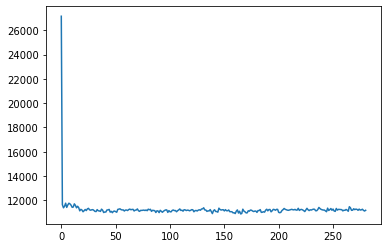

In [455]:
df_rolling.loc[df_rolling["id"]=="80_1024_1_6_4_CGM_p77_24h_2_3_400_CGM","time"].plot()
plt.show()


In [458]:
df_rolling.pivot_table(values="time", index=["func","level"], columns=["data", "base_log"], aggfunc="median")


data       CGM_p77_24h_2_3_400                                      \
base_log                     3        4        5        6        7   
func level                                                           
CGM  3                     NaN      NaN   8986.0      NaN      NaN   
     4                     NaN      NaN      NaN  11199.0      NaN   
     5                     NaN      NaN  13092.0      NaN      NaN   
     6                     NaN  15492.0      NaN  15275.0      NaN   
TIR  3                     NaN      NaN   8797.0   8781.0   8867.0   
     4                     NaN      NaN  11139.0      NaN  11157.0   
     5                 13324.0      NaN  13261.0  13350.5      NaN   
     6                     NaN  15613.0  15544.0  15533.0      NaN   
     7                 17739.0  17548.0  17549.0  17487.0  17830.0   

data       CGM_p77_24h_3_3_400                  CGM_p77_24h_4_3_400          \
base_log                     4       5        6                   4       5   
func level                                                                    
CGM  3                     NaN     NaN      NaN                 NaN     NaN   
     4                     NaN     NaN   7282.0                 NaN     NaN   
     5                     NaN  8855.0      NaN                 NaN  4478.0   
     6                 10204.5     NaN  10177.0              5188.5     NaN   
TIR  3                     NaN     NaN      NaN                 NaN     NaN   
     4                     NaN     NaN   7461.0                 NaN     NaN   
     5                     NaN  8874.0      NaN                 NaN  4451.0   
     6                 10529.0     NaN  10410.0              5214.0     NaN   
     7                     NaN     NaN      NaN                 NaN     NaN   

data                
base_log         6  
func level          
CGM  3         NaN  
     4      3616.0  
     5         NaN  
     6      5122.0  
TIR  3         NaN  
     4      3718.0  
     5         NaN  
     6      5218.0  
     7         NaN